<a href="https://colab.research.google.com/github/Adeyinka-hub/MY-MACHINE-LEARNING-AND-DEEP-LEARNING-WORKS-ON-KAGGLE-AND-ZINDI-RESPECTIVELY/blob/master/KAGGLE-TWEETER%20DISASTER%20CHALLENGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix, f1_score

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [ ]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Text(0, 0.5, 'Number of samples')

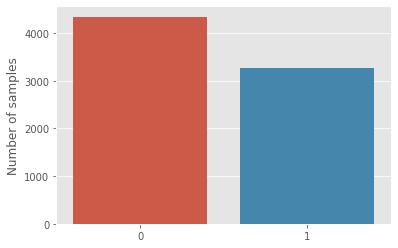

In [ ]:
## EDA
## Class distribution
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

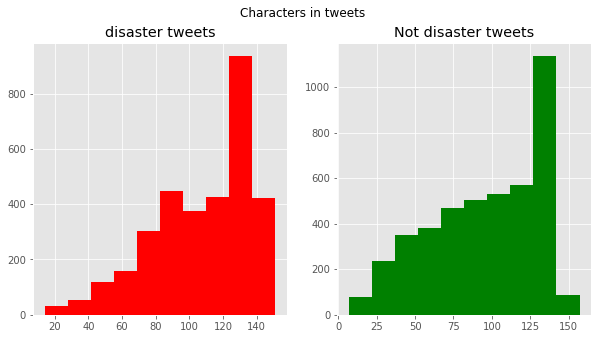

In [ ]:
## Number of characters in tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()


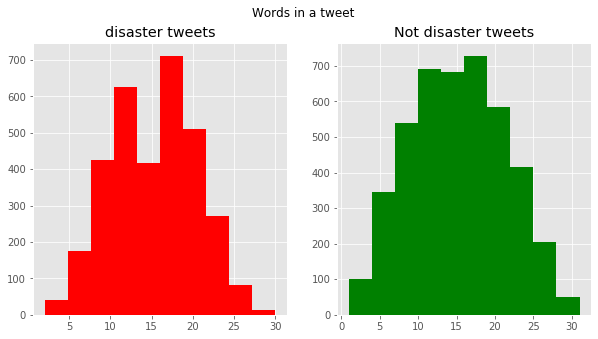

In [ ]:
## Number of words in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

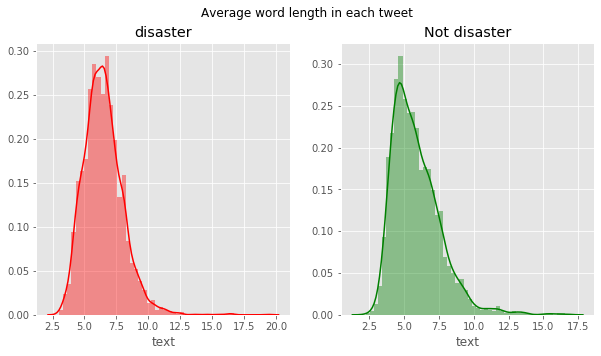

In [ ]:
## Average word length in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [ ]:
## Number of tweets in dataset according to location
cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [ ]:
## Number of tweets depending on location per class
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)


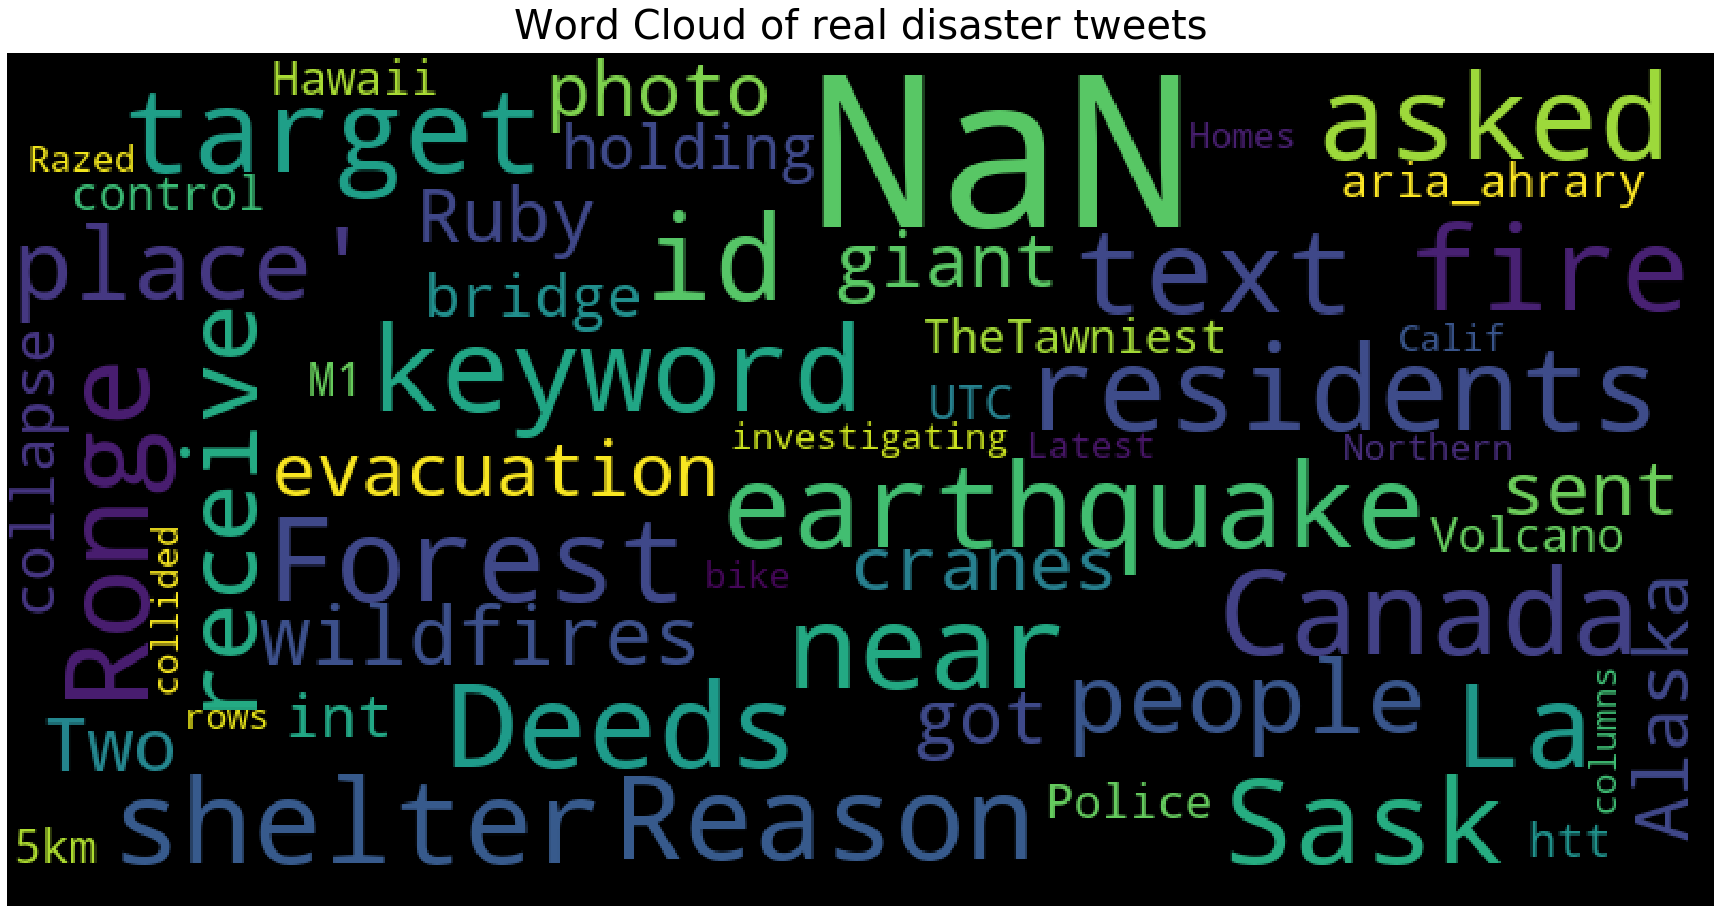

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train[train["target"]==1], title="Word Cloud of real disaster tweets")


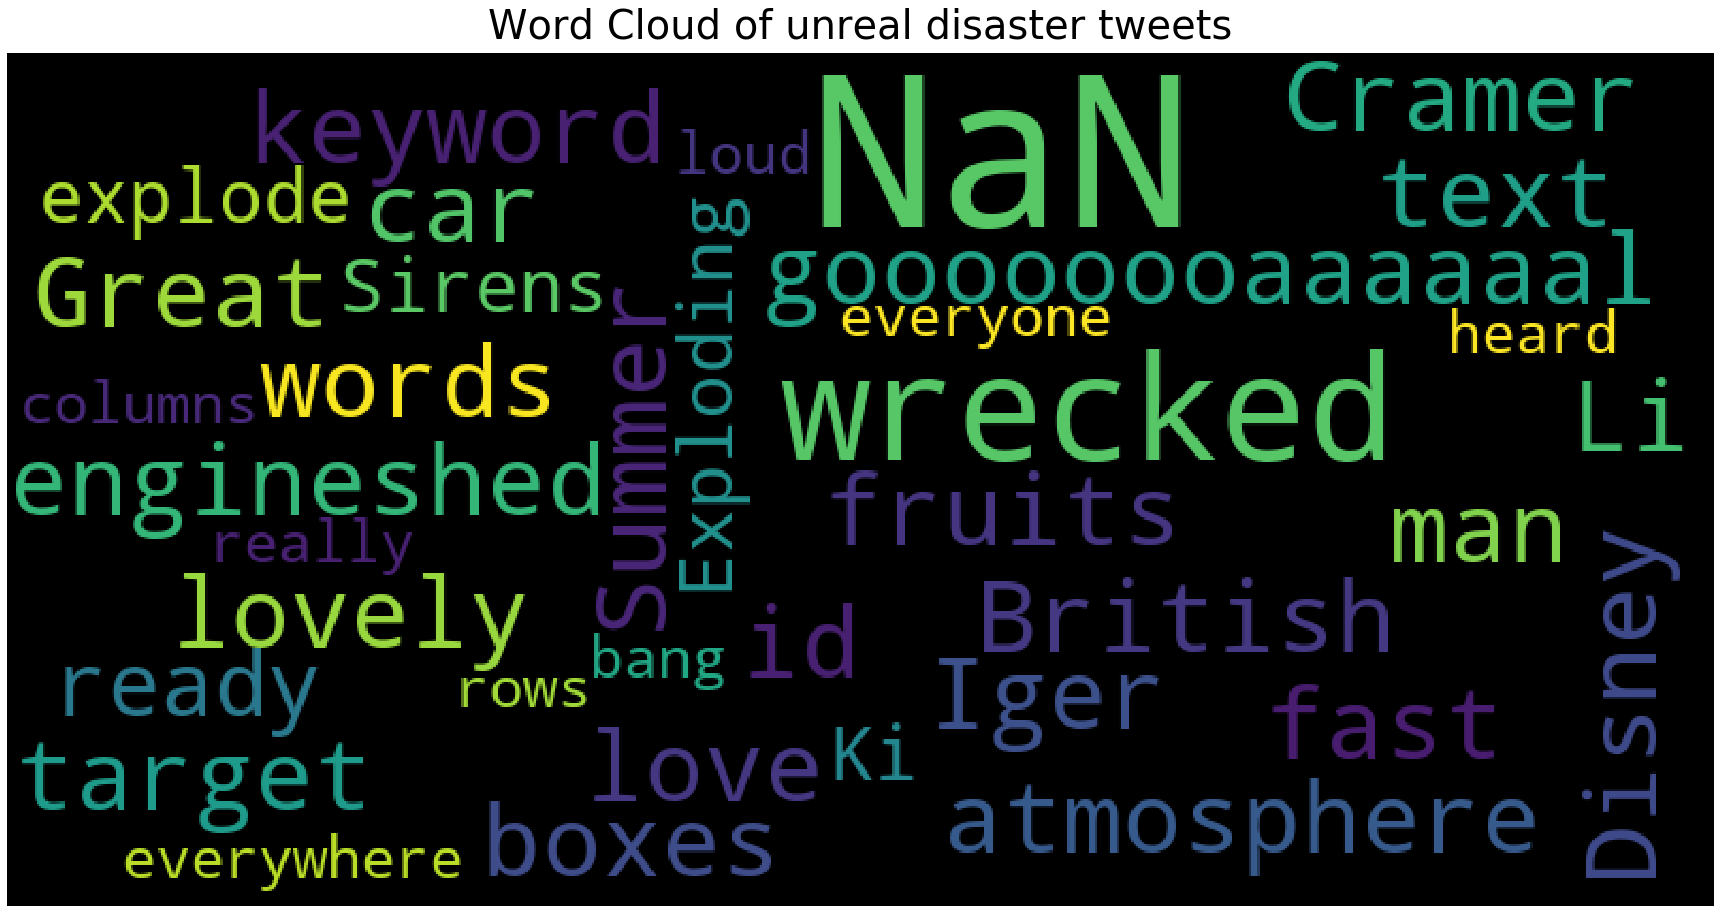

In [ ]:
plot_wordcloud(train[train["target"]==0], title="Word Cloud of unreal disaster tweets")

**Common stopwords**

In [ ]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


In [ ]:
from nltk.corpus import stopwords
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]



plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

In [ ]:
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    return text


train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)


In [ ]:
def massage_text(text):
    import re
    from nltk.corpus import stopwords


In [ ]:
## remove anything other then characters and put everything in lowercase
    import uuid
    import re
    tweet = re.sub("[^a-zA-Z]", ' ', text)
    tweet = tweet.lower()
    tweet = tweet.split()

    from nltk.stem import WordNetLemmatizer
    lem = WordNetLemmatizer()
    tweet = [lem.lemmatize(word) for word in tweet
             if word not in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    return tweet
    print('--here goes nothing')
    print(text)
    print(tweet)

train['clean_text'] = train['text'].apply(massage_text)
test['clean_text'] = test['text'].apply(massage_text)


In [ ]:
train.iloc[0:10][['text','clean_text']]

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this #earthquake m...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada
2,All residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby #alaska as ...
5,#RockyFire Update => California Hwy. 20 closed...,#rockyfire update => california hwy. 20 closed...
6,#flood #disaster Heavy rain causes flash flood...,#flood #disaster heavy rain causes flash flood...
7,I'm on top of the hill and I can see a fire in...,i am on top of the hill and i can see a fire i...
8,There's an emergency evacuation happening now ...,there is an emergency evacuation happening now...
9,I'm afraid that the tornado is coming to our a...,i am afraid that the tornado is coming to our ...


In [ ]:
## Baseline models
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

X_train,X_test,y_train,y_test = train_test_split(train['clean_text'],train['target'])

tfidf = TfidfVectorizer()

train_vector = tfidf.fit_transform(X_train)
test_vector = tfidf.transform(X_test)

In [ ]:
models = (xgb.XGBClassifier(random_state = 1),
         RandomForestClassifier(random_state = 1),
         GradientBoostingClassifier(random_state = 1),
         lgb.LGBMClassifier(random_state = 1),
         LogisticRegression(random_state = 1))

for model in models:
    model.fit(train_vector, y_train)
    predict = model.predict(test_vector)
    print(f1_score(y_test,predict))
0.6276021588280648


0.6376383763837639
0.7088425593098491
0.6593886462882096
0.727634194831014
0.7411842980705257


0.6276021588280648

In [ ]:
## Automated stacking
## In order to automate stacking I'll use vecstack package.
from vecstack import stacking

In [ ]:
S_train, S_test = stacking(models,                   
                           train_vector, y_train, test_vector,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=f1_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

In [ ]:
model = LogisticRegression(random_state=0)
    
model = model.fit(S_train, y_train)

y_pred = model.predict(S_test)

print(f1_score(y_test,predict))


In [ ]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 1.9MB/s 


In [ ]:
from bert.tokenization import FullTokenizer

In [ ]:
!pip install  --upgrade bert

  Created wheel for bert: filename=bert-2.2.0-cp36-none-any.whl size=3756 sha256=3cbf1d9107e147ab7fa15d0794ae4744aa1a488dc81ac19e65d2f5f76a6ece64
  Stored in directory: /root/.cache/pip/wheels/fe/71/b7/941459453bd38e5d97a8c886361dee19325e9933c9cf88ad46
  Created wheel for erlastic: filename=erlastic-2.0.0-cp36-none-any.whl size=6786 sha256=b2332e5881fd65803990b87c6eae16c0a9a75c0641546c313af4c3d0381b4dd3
  Stored in directory: /root/.cache/pip/wheels/02/62/46/93c713a5f061aeeb4f16eb6bf5ee798816e6ddda70faa78e69
Successfully built bert erlastic


In [ ]:

!pip install  --upgrade bert-tensorflow

Requirement already up-to-date: bert-tensorflow in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
%%time
#module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)
CPU times: user 1min 23s, sys: 4.61 s, total: 1min 27s


In [ ]:
import pandas as pd
import numpy as np
import os
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")


In [ ]:
import re
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values


In [ ]:
## Model: Build, Train, Predict, Submit
model = build_model(bert_layer, max_len=160)
model.summary()
Model: "model"


In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)
Train on 6090 samples, validate 


In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)


In [ ]:
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)
